#**Summer started in 1896.**

#**Winter started in 1926.**

#**Summer and Winter split for the 92 summer/94 winter.**

#**1916, 1940, and 1944 had no Olympics.**

# Fin's rough_sort data notes
### !! teams still have incorrect medals values !!
### without disipline and event, some events are incomprehensible
### running the code should download the rough_sort into the colab container, the code to download to machine is commented out.

## !! UNTILL TEAM MEDALS ARE PROPER ALL ANALYSIS IS SHADY

# advice from aaron

## calculate basline. Pick criteion
- make simple prediciton with limited features, this will be the baseline that we try to beat by adding features. e.g., mean medals yearly.

## exploratory analysis
- trend over time; possible medals, particular countries attempts, proportions of participations
- countries specialize

In [229]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

summer = pd.read_csv('/content/summer.csv')
winter = pd.read_csv('/content/winter.csv')
c_codes = pd.read_csv('/content/dictionary.csv')
c_codes = c_codes.drop(columns=['Population', 'GDP per Capita'])
# #athlete = pd.read_csv('/content/athlete_events.csv')

In [230]:
print(len(summer))
print(len(winter))
#print(len(athlete))

31165
5770


# Data Processing steps
1. split medal (str) into bronze, silver, gold (ints)
2. split df into yearwise df's
  - create dict with (year, df_year) with all years
3. add year column back in
4. add event counts to each year
5. concate all yearwise into full length df

In [231]:
# 1.

#  splitting medals into numerical values of bronze, silver, or gold
summer['Gold'] = summer[['Medal']].applymap(lambda x : 1 if x == "Gold" else 0)
summer['Silver'] = summer[['Medal']].applymap(lambda x : 1 if x == "Silver" else 0)
summer['Bronze'] = summer[['Medal']].applymap(lambda x : 1 if x == "Bronze" else 0)
winter['Gold'] = winter[['Medal']].applymap(lambda x : 1 if x == "Gold" else 0)
winter['Silver'] = winter[['Medal']].applymap(lambda x : 1 if x == "Silver" else 0)
winter['Bronze'] = winter[['Medal']].applymap(lambda x : 1 if x == "Bronze" else 0)
summer.columns

Index(['Year', 'City', 'Sport', 'Discipline', 'Athlete', 'Country', 'Gender',
       'Event', 'Medal', 'Gold', 'Silver', 'Bronze'],
      dtype='object')

In [232]:
def split_dataframe_by_year(df):
    """
    Split a DataFrame into multiple DataFrames based on the 'Year' column.

    Args:
    df (pd.DataFrame): Input DataFrame with a 'Year' column.

    Returns:
    dict: A dictionary where keys are unique years and values are corresponding DataFrames.
    """
    # Check if 'Year' column exists in the DataFrame
    if 'Year' not in df.columns:
        raise ValueError("DataFrame must have a 'Year' column.")

    # Split the DataFrame into multiple DataFrames based on 'Year'
    yearwise_dfs = {}
    unique_years = df['Year'].unique()

    for year in unique_years:
        yearwise_dfs[year] = df[df['Year'] == year]

    return yearwise_dfs

In [233]:
# 2.
yearwise_summers = split_dataframe_by_year(summer)
yearwise_winters = split_dataframe_by_year(winter)
# Finding the years that exist in either summer or winter dictionaries. | == 'or'
combined_years = set(yearwise_summers.keys()) | set(yearwise_winters.keys())

# Dictionary to store concatenated yearwise DataFrames
yearwise_all = {}

# Iterate through combined years and concatenate the paired DataFrames
for year in combined_years:
    # Concatenate the paired DataFrames for the current year and store in the dictionary
    concatenated_df = pd.concat([yearwise_summers.get(year, pd.DataFrame()),
                                 yearwise_winters.get(year, pd.DataFrame())], axis=0)
    yearwise_all[year] = concatenated_df

In [234]:
# dictionary in the form (year, dataframe) for years:
#     [1920, 1924, 1928, 1932, 1936, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992,
#     [1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 1896, 1900, 1904, 1908, 1912]
yearwise_all[1896] # to call the dataframe from a specific year


,Year,City,Sport,Discipline,Athlete,Country,Gender,Event,Medal,Gold,Silver,Bronze
0,1896,Athens,Aquatics,Swimming,"HAJOS, Alfred",HUN,Men,100M Freestyle,Gold,1,0,0
1,1896,Athens,Aquatics,Swimming,"HERSCHMANN, Otto",AUT,Men,100M Freestyle,Silver,0,1,0
2,1896,Athens,Aquatics,Swimming,"DRIVAS, Dimitrios",GRE,Men,100M Freestyle For Sailors,Bronze,0,0,1
3,1896,Athens,Aquatics,Swimming,"MALOKINIS, Ioannis",GRE,Men,100M Freestyle For Sailors,Gold,1,0,0
4,1896,Athens,Aquatics,Swimming,"CHASAPIS, Spiridon",GRE,Men,100M Freestyle For Sailors,Silver,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
146,1896,Athens,Weightlifting,Weightlifting,"JENSEN, Viggo",DEN,Men,Heavyweight - Two Hand Lift,Gold,1,0,0
147,1896,Athens,Weightlifting,Weightlifting,"ELLIOTT, Launceston",GBR,Men,Heavyweight - Two Hand Lift,Silver,0,1,0
148,1896,Athens,Wrestling,Wrestling Gre-R,"CHRISTOPOULOS, Stephanos",GRE,Men,Open Event,Bronze,0,0,1
149,1896,Athens,Wrestling,Wrestling Gre-R,"SCHUMANN, Carl",GER,Men,Open Event,Gold,1,0,0


In [235]:
# parallel ML idea: try multiple ML trials with different granulaity of groups. I.e., Event is most specific, disipline is moderately spcific and sport is unspecific.
# try to compare effect given the different spcificity that the bot knows
def group_by_country_event(df):
    """
    Group a DataFrame by 'Country' and 'Event' and aggregate the 'Bronze', 'Silver', and 'Gold' columns.

    Args:
    df (pd.DataFrame): Input DataFrame with columns ['Country', 'Event', 'Bronze', 'Silver', 'Gold'].

    Returns:
    pd.DataFrame: Grouped DataFrame with 'Bronze', 'Silver', and 'Gold' columns summed up per country and event.
    """
    grouped_df = df.groupby(['Country', 'Gender',  'Sport', 'Discipline','Event']).agg({
        'Bronze': 'sum',
        'Silver': 'sum',
        'Gold': 'sum'
    }).reset_index()
    return grouped_df

# Example usage:
# Assuming you have a dictionary of yearwise DataFrames named 'yearwise_all'
# grouped_yearwise_data = {year: group_by_country_event(df) for year, df in yearwise_all.items()}
# grouped_df[grouped_df['Country']== 'USA']

In [236]:
def add_key_column_to_dataframes(dataframes_dict):
    """
    Add a column to each DataFrame in the dictionary with the corresponding key value.

    Args:
    dataframes_dict (dict): A dictionary where keys are integers and values are DataFrames.

    Returns:
    dict: A modified dictionary with DataFrames containing an additional column with the key value.
    """
    modified_dataframes_dict = {}
    for key, df in dataframes_dict.items():
        # Adding a new column with the key value
        df['Key_Column'] = key
        # Storing the modified DataFrame in the new dictionary
        modified_dataframes_dict[key] = df
    return modified_dataframes_dict

# Example usage:
# Assuming you have a dictionary named 'dataframes_dict' with (integer, DataFrame) pairs
# modified_dataframes_dict = add_key_column_to_dataframes(dataframes_dict)


In [237]:
def add_event_total(df_dict):
  """
  count number of unique events and adds them as a column
  """
  new_dict = {}
  for key, df in df_dict.items():
    df['Event Total'] = len(df['Event'])
    new_dict[key] = df
  return new_dict


In [238]:
# 3.

grouped_yearwise_dict = {year: group_by_country_event(df) for year, df in yearwise_all.items()}
modified_dataframes_dict = add_key_column_to_dataframes(grouped_yearwise_dict)
modified_dataframes_dict[1896]
event_tots = add_event_total(modified_dataframes_dict)
event_tots[2014]

,Country,Gender,Sport,Discipline,Event,Bronze,Silver,Gold,Key_Column,Event Total
0,AUS,Men,Skiing,Freestyle Skiing,Aerials,0,1,0,2014,265
1,AUS,Women,Skiing,Freestyle Skiing,Aerials,1,0,0,2014,265
2,AUS,Women,Skiing,Snowboard,Half-Pipe,0,1,0,2014,265
3,AUT,Men,Biathlon,Biathlon,10KM,0,1,0,2014,265
4,AUT,Men,Biathlon,Biathlon,4X7.5KM Relay,4,0,0,2014,265
...,...,...,...,...,...,...,...,...,...,...
260,USA,Women,Skiing,Freestyle Skiing,Moguls,1,0,0,2014,265
261,USA,Women,Skiing,Freestyle Skiing,Ski Halfpipe,0,0,1,2014,265
262,USA,Women,Skiing,Freestyle Skiing,Ski Slopestyle,0,1,0,2014,265
263,USA,Women,Skiing,Snowboard,Half-Pipe,1,0,1,2014,265


In [239]:
c_codes

,Country,Code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,ALG
3,American Samoa*,ASA
4,Andorra,AND
...,...,...
196,Vietnam,VIE
197,Virgin Islands*,ISV
198,Yemen,YEM
199,Zambia,ZAM


In [240]:
def add_event_count_with_names(data_dict, c_codes):
    # Initialize an empty dictionary to store the result dataframes
    result_dict = {}

    # Iterate through each (year, dataframe) pair in the dictionary
    for year, dataframe in data_dict.items():
        # Group by country and count the number of events for each country
        country_event_counts = dataframe.groupby('Country').size().reset_index(name='Event_Count')

        # Merge with the country codes dataframe to get country names
        merged_df = pd.merge(dataframe, country_event_counts, how='left', on='Country')
        merged_df = pd.merge(merged_df, c_codes, how='left', left_on='Country', right_on='Code')

        # Drop the extra 'code' column
        merged_df = merged_df.drop(columns=['Code'])

        # Add the result dataframe to the dictionary
        result_dict[year] = merged_df

    return result_dict

In [241]:
"""
EUA -> GER
FRG -> GER
GDR -> GER
ANZ -> AUS
BOH -> TCH
BWI -> JAM
IOP -> YUG
EUN -> RUS
URS -> RUS
RU1 -> RUS
MNE - Montenegro
ROU - Romania
SGP - Singapore
SRB - Serbia
TCH - Czechoslovakia
TTO - Trinidad and Tobago
YUG - Yugoslavia
ZZX - Independent
"""
plus_c_names = {
    'GDR' : 'Germany',
    'EUN' : 'Russia',
    'IOP' : 'Yugoslavia',
    'BOH' : 'Czechoslovakia',
    'ANZ' : 'Australia',
    'URS' : 'Russia',
    'FRG' : 'Germany',
    'EUA' : 'Germany',
    'BWI' : 'Jamaica',
    'RU1': 'Russia',
    'MNE': 'Montenegro',
    'ROU': 'Romania',
    'SGP': 'Singapore',
    'SRB': 'Serbia',
    'TCH': 'Czechoslovakia',
    'TTO': 'Trinidad and Tobago',
    'YUG': 'Yugoslavia',
    'ZZX': 'Independent'
}


In [242]:
# 4. 5.
for code, country in plus_c_names.items():
    c_codes.loc[len(c_codes)] = [country, code]
c = c_codes
c_codes
events_num = add_event_count_with_names(event_tots, c_codes)
concatenated_df = pd.concat(events_num.values(), keys=events_num.keys(), ignore_index=True)


# Printing the concatenated DataFrame
rough_sort=concatenated_df.sort_values(by='Key_Column', ascending=True)

rough_sort.loc[rough_sort['Gold'] > 1, 'Gold'] = 1
rough_sort.loc[rough_sort['Silver'] > 1, 'Silver'] = 1
rough_sort.loc[rough_sort['Bronze'] > 1, 'Bronze'] = 1

rough_sort[rough_sort['Country_x']== 'RU1']

,Country_x,Gender,Sport,Discipline,Event,Bronze,Silver,Gold,Key_Column,Event Total,Event_Count,Country_y
15255,RU1,Men,Skating,Figure skating,Special Figures,0,0,1,1908,220,3,Russia
15256,RU1,Men,Wrestling,Wrestling Gre-R,+ 93KG (Super Heavyweight),0,1,0,1908,220,3,Russia
15257,RU1,Men,Wrestling,Wrestling Gre-R,- 66.6KG (Lightweight),0,1,0,1908,220,3,Russia
15465,RU1,Men,Sailing,Sailing,10M,1,0,0,1912,247,5,Russia
15466,RU1,Men,Shooting,Shooting,"30M Army Pistol, Team",0,1,0,1912,247,5,Russia
15467,RU1,Men,Shooting,Shooting,Trap (125 Targets),1,0,0,1912,247,5,Russia
15468,RU1,Men,Wrestling,Wrestling Gre-R,67.5 - 75KG (Middleweight),0,1,0,1912,247,5,Russia
15464,RU1,Men,Rowing,Rowing,Single Sculls (1X),1,0,0,1912,247,5,Russia


In [243]:
df = concatenated_df
print(len(df[df['Sport']=='Aquatics']))
print(len(df[df['Discipline']=='Swimming']))
print(len(df[df['Event']=='100M Freestyle']))
events_num.keys()

1687
1301
113


dict_keys([1920, 1924, 1928, 1932, 1936, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 1896, 1900, 1904, 1908, 1912])

In [244]:
rough_sort

,Country_x,Gender,Sport,Discipline,Event,Bronze,Silver,Gold,Key_Column,Event Total,Event_Count,Country_y
14703,AUS,Men,Athletics,Athletics,1500M,0,0,1,1896,89,2,Australia
14767,GRE,Men,Weightlifting,Weightlifting,Heavyweight - One Hand Lift,1,0,0,1896,89,28,Greece
14766,GRE,Men,Tennis,Tennis,Singles,1,1,0,1896,89,28,Greece
14765,GRE,Men,Shooting,Shooting,"Army Rifle, 300M",0,1,1,1896,89,28,Greece
14764,GRE,Men,Shooting,Shooting,"Army Rifle, 200M",1,1,1,1896,89,28,Greece
...,...,...,...,...,...,...,...,...,...,...,...,...
14607,POL,Men,Skiing,Ski Jumping,Large Hill,0,0,1,2014,265,6,Poland
14608,POL,Men,Skiing,Ski Jumping,Normal Hill,0,0,1,2014,265,6,Poland
14609,POL,Women,Skating,Speed skating,Team Pursuit,0,1,0,2014,265,6,Poland
14593,NOR,Men,Skiing,Nordic Combined,"Team, 4X5 KM",0,0,1,2014,265,22,Norway


In [245]:
# Saving the DataFrame to a CSV file in Colab's temporary directory
csv_file_path = '/content/rough_sort.csv'  # Set the desired file path

rough_sort.to_csv(csv_file_path, index=False)  # Set index=False to exclude the index column in the CSV file

# Generating a download link for the CSV file
#from google.colab import files
#files.download(csv_file_path)

<Axes: xlabel='Country_y'>

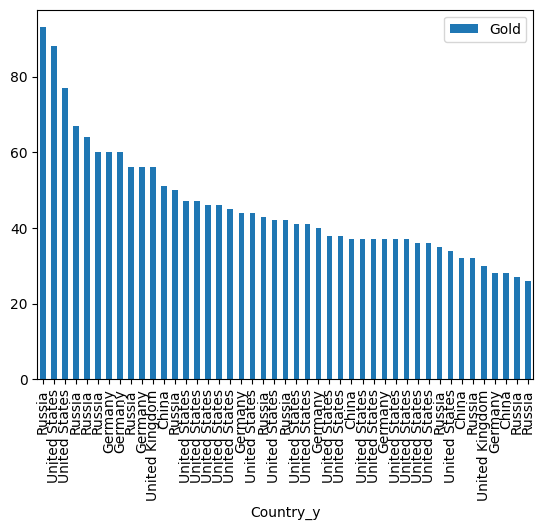

In [246]:
gdf = rough_sort.groupby(['Country_y', 'Key_Column']).agg({
        'Bronze': 'sum',
        'Silver': 'sum',
        'Gold': 'sum'
    }).reset_index()
g = gdf.sort_values('Gold', ascending = False)
g[:45].plot.bar(x = 'Country_y', y = 'Gold')

<Axes: xlabel='Country_y'>

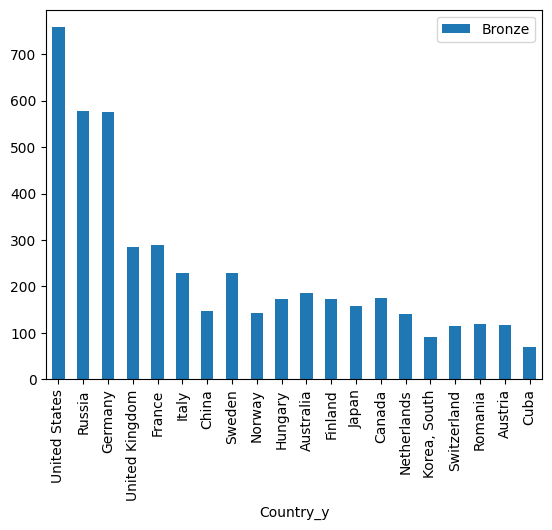

In [247]:
#sort countries by total golds ever won
agg_functions = {'Country_y':'first','Bronze':'sum','Silver':'sum','Gold':'sum'}
ggdf = rough_sort.groupby(rough_sort['Country_y']).aggregate(agg_functions)
gg = ggdf.sort_values('Gold', ascending = False)
gg[:20].plot.bar(x = 'Country_y', y = 'Bronze')

In [248]:
gg

,Country_y,Bronze,Silver,Gold
Country_y,,,,
United States,United States,758,864,1076
Russia,Russia,577,593,727
Germany,Germany,575,573,561
United Kingdom,United Kingdom,285,285,252
France,France,290,250,236
...,...,...,...,...
Eritrea,Eritrea,1,0,0
Saudi Arabia,Saudi Arabia,2,1,0
Kuwait,Kuwait,2,0,0


<Axes: xlabel='Country_x'>

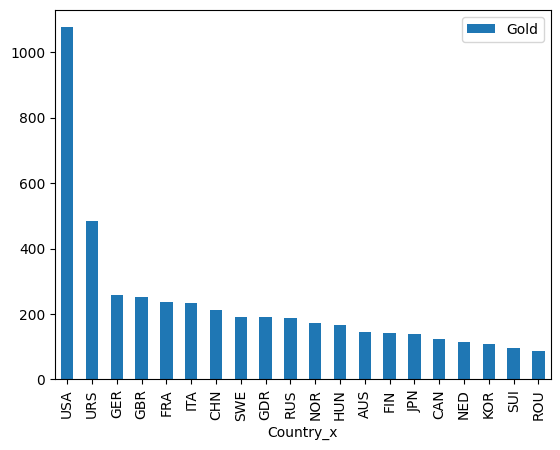

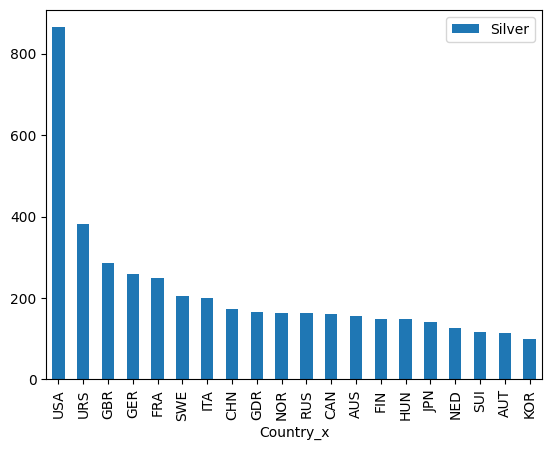

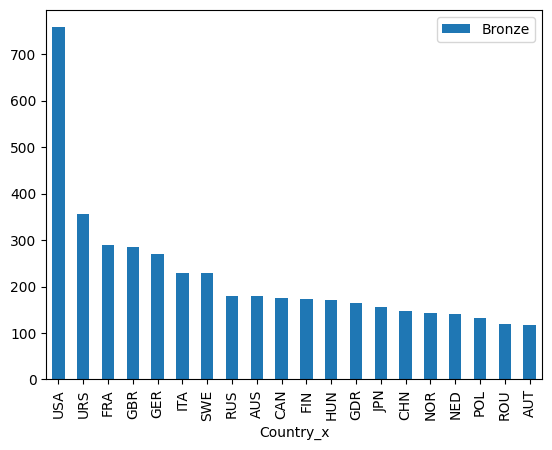

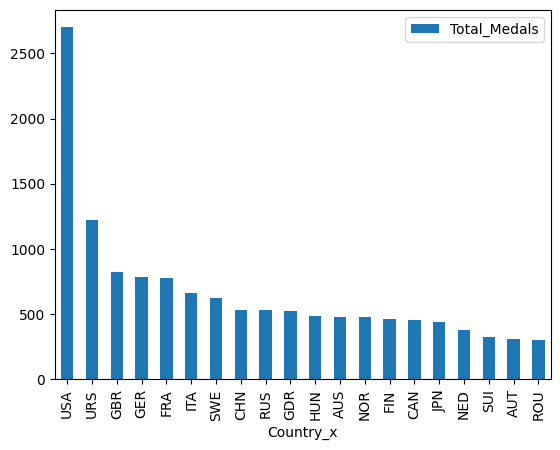

In [249]:
agg_functions = {'Country_x':'first','Bronze':'sum','Silver':'sum','Gold':'sum'}
ggdf = rough_sort.groupby(rough_sort['Country_x']).aggregate(agg_functions)
gg = ggdf.sort_values('Gold', ascending = False)

# 3 Graphs showing the medals won by each country
gg[:20].plot.bar(x = 'Country_x', y = 'Gold')
gg = ggdf.sort_values('Silver', ascending = False)
gg[:20].plot.bar(x = 'Country_x', y = 'Silver')
gg = ggdf.sort_values('Bronze', ascending = False)
gg[:20].plot.bar(x = 'Country_x', y = 'Bronze')

ggdf['Total_Medals'] = ggdf['Bronze'] + ggdf['Silver'] + ggdf['Gold']
#See total medals per country
gg = ggdf.sort_values('Total_Medals', ascending = False)
gg[:20].plot.bar(x = 'Country_x', y = 'Total_Medals')

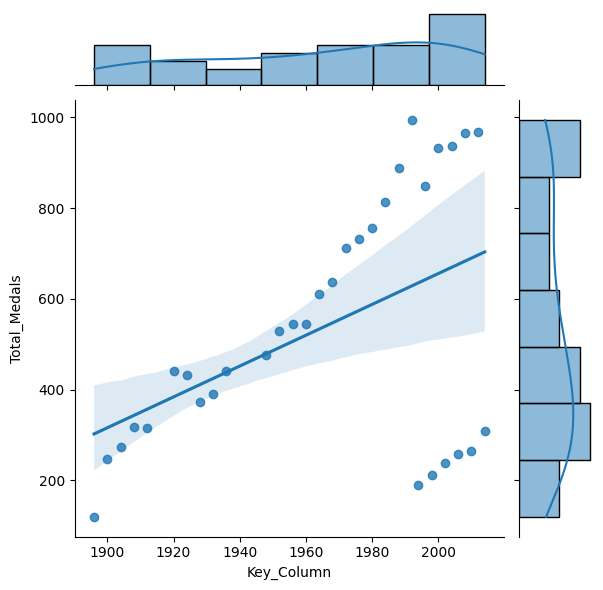

In [250]:
agg_functions = {'Key_Column':'first','Bronze':'sum','Silver':'sum','Gold':'sum' ,'Event_Count':'count'}
ggdf = rough_sort.groupby(rough_sort['Key_Column']).aggregate(agg_functions)

ggdf['Total_Medals'] = ggdf['Bronze'] + ggdf['Silver'] + ggdf['Gold']

sns.jointplot(x=ggdf['Key_Column'], y=ggdf['Total_Medals'], kind='reg')

In [251]:
df[df['Country_x']== 'RU1']

,Country_x,Gender,Sport,Discipline,Event,Bronze,Silver,Gold,Key_Column,Event Total,Event_Count,Country_y
15255,RU1,Men,Skating,Figure skating,Special Figures,0,0,1,1908,220,3,Russia
15256,RU1,Men,Wrestling,Wrestling Gre-R,+ 93KG (Super Heavyweight),0,1,0,1908,220,3,Russia
15257,RU1,Men,Wrestling,Wrestling Gre-R,- 66.6KG (Lightweight),0,1,0,1908,220,3,Russia
15464,RU1,Men,Rowing,Rowing,Single Sculls (1X),1,0,0,1912,247,5,Russia
15465,RU1,Men,Sailing,Sailing,10M,7,0,0,1912,247,5,Russia
15466,RU1,Men,Shooting,Shooting,"30M Army Pistol, Team",0,4,0,1912,247,5,Russia
15467,RU1,Men,Shooting,Shooting,Trap (125 Targets),1,0,0,1912,247,5,Russia
15468,RU1,Men,Wrestling,Wrestling Gre-R,67.5 - 75KG (Middleweight),0,1,0,1912,247,5,Russia


# rough sort to med_sort

## geo dict


In [252]:
geo_region = {
    'Afghanistan': ['Asia', 'Southern Asia'],
    'Albania': ['Europe', 'Southern Europe'],
    'Algeria': ['Africa', 'Northern Africa'],
    'American Samoa*': ['Oceania', 'Polynesia'],
    'Andorra': ['Europe', 'Southern Europe'],
    'Angola': ['Africa', 'Middle Africa'],
    'Antigua and Barbuda': ['Americas', 'Latin America and the Caribbean'],
    'Argentina': ['Americas', 'Latin America and the Caribbean'],
    'Armenia': ['Asia', 'Western Asia'],
    'Aruba*': ['Americas', 'Latin America and the Caribbean'],
    'Australia': ['Oceania', 'Australia and New Zealand'],
    'Austria': ['Europe', 'Western Europe'],
    'Azerbaijan': ['Asia', 'Western Asia'],
    'Bahamas': ['Americas', 'Latin America and the Caribbean'],
    'Bahrain': ['Asia', 'Western Asia'],
    'Bangladesh': ['Asia', 'Southern Asia'],
    'Barbados': ['Americas', 'Latin America and the Caribbean'],
    'Belarus': ['Europe', 'Eastern Europe'],
    'Belgium': ['Europe', 'Western Europe'],
    'Belize': ['Americas', 'Latin America and the Caribbean'],
    'Bermuda*': ['Americas', 'Northern America'],
    'Benin': ['Africa', 'Western Africa'],
    'Bhutan': ['Asia', 'Southern Asia'],
    'Bolivia': ['Americas', 'Latin America and the Caribbean'],
    'Bosnia and Herzegovina': ['Europe', 'Southern Europe'],
    'Botswana': ['Africa', 'Southern Africa'],
    'Brazil': ['Americas', 'Latin America and the Caribbean'],
    'British Virgin Islands': ['Americas', 'Latin America and the Caribbean'],
    'Brunei': ['Asia', 'South-eastern Asia'],
    'Bulgaria': ['Europe', 'Eastern Europe'],
    'Burkina Faso': ['Africa', 'Western Africa'],
    'Burundi': ['Africa', 'Eastern Africa'],
    'Cambodia': ['Asia', 'South-eastern Asia'],
    'Cameroon': ['Africa', 'Middle Africa'],
    'Canada': ['Americas', 'Northern America'],
    'Cape Verde': ['Africa', 'Western Africa'],
    'Cayman Islands*': ['Americas', 'Latin America and the Caribbean'],
    'Central African Republic': ['Africa', 'Middle Africa'],
    'Chad': ['Africa', 'Middle Africa'],
    'Chile': ['Americas', 'Latin America and the Caribbean'],
    'China': ['Asia', 'Eastern Asia'],
    'Colombia': ['Americas', 'Latin America and the Caribbean'],
    'Comoros': ['Africa', 'Eastern Africa'],
    'Congo': ['Africa', 'Middle Africa'],
    'Congo, Dem Rep': ['Africa', 'Middle Africa'],
    'Cook Islands': ['Oceania', 'Polynesia'],
    'Costa Rica': ['Americas', 'Latin America and the Caribbean'],
    "Cote d'Ivoire": ['Africa', 'Western Africa'],
    'Croatia': ['Europe', 'Southern Europe'],
    'Cuba': ['Americas', 'Latin America and the Caribbean'],
    'Cyprus': ['Asia', 'Western Asia'],
    'Czech Republic': ['Europe', 'Eastern Europe'],
    'Denmark': ['Europe', 'Northern Europe'],
    'Djibouti': ['Africa', 'Eastern Africa'],
    'Dominica': ['Americas', 'Latin America and the Caribbean'],
    'Dominican Republic': ['Americas', 'Latin America and the Caribbean'],
}

geo_region.update({
    'East Timor (Timor-Leste)': ['Asia', 'South-eastern Asia'],
    'Ecuador': ['Americas', 'Latin America and the Caribbean'],
    'Egypt': ['Africa', 'Northern Africa'],
    'El Salvador': ['Americas', 'Latin America and the Caribbean'],
    'Equatorial Guinea': ['Africa', 'Middle Africa'],
    'Eritrea': ['Africa', 'Eastern Africa'],
    'Estonia': ['Europe', 'Northern Europe'],
    'Ethiopia': ['Africa', 'Eastern Africa'],
    'Fiji': ['Oceania', 'Melanesia'],
    'Finland': ['Europe', 'Northern Europe'],
    'France': ['Europe', 'Western Europe'],
    'Gabon': ['Africa', 'Middle Africa'],
    'Gambia': ['Africa', 'Western Africa'],
    'Georgia': ['Asia', 'Western Asia'],
    'Germany': ['Europe', 'Western Europe'],
    'Ghana': ['Africa', 'Western Africa'],
    'Greece': ['Europe', 'Southern Europe'],
    'Grenada': ['Americas', 'Latin America and the Caribbean'],
    'Guam': ['Oceania', 'Micronesia'],
    'Guatemala': ['Americas', 'Latin America and the Caribbean'],
    'Guinea': ['Africa', 'Western Africa'],
    'Guinea-Bissau': ['Africa', 'Western Africa'],
    'Guyana': ['Americas', 'Latin America and the Caribbean'],
    'Haiti': ['Americas', 'Latin America and the Caribbean'],
    'Honduras': ['Americas', 'Latin America and the Caribbean'],
    'Hong Kong*': ['Asia', 'Eastern Asia'],
    'Hungary': ['Europe', 'Eastern Europe'],
    'Iceland': ['Europe', 'Northern Europe'],
    'India': ['Asia', 'Southern Asia'],
    'Indonesia': ['Asia', 'South-eastern Asia'],
    'Iran': ['Asia', 'Southern Asia'],
    'Iraq': ['Asia', 'Western Asia'],
    'Ireland': ['Europe', 'Northern Europe'],
    'Israel': ['Asia', 'Western Asia'],
    'Italy': ['Europe', 'Southern Europe'],
    'Jamaica': ['Americas', 'Latin America and the Caribbean'],
    'Japan': ['Asia', 'Eastern Asia'],
    'Jordan': ['Asia', 'Western Asia'],
    'Kazakhstan': ['Asia', 'Central Asia'],
    'Kenya': ['Africa', 'Eastern Africa'],
    'Korea, North': ['Asia', 'Eastern Asia'],
    'Korea, South': ['Asia', 'Eastern Asia'],
    'Kuwait': ['Asia', 'Western Asia'],
    'Kyrgyzstan': ['Asia', 'Central Asia'],
    'Laos': ['Asia', 'South-eastern Asia'],
    'Latvia': ['Europe', 'Northern Europe'],
    'Lebanon': ['Asia', 'Western Asia'],
    'Lesotho': ['Africa', 'Southern Africa'],
    'Liberia': ['Africa', 'Western Africa'],
    'Libya': ['Africa', 'Northern Africa'],
    'Liechtenstein': ['Europe', 'Western Europe'],
    'Lithuania': ['Europe', 'Northern Europe'],
    'Luxembourg': ['Europe', 'Western Europe'],
    'Macedonia': ['Europe', 'Southern Europe'],
    'Madagascar': ['Africa', 'Eastern Africa'],
    'Malawi': ['Africa', 'Eastern Africa'],
})

geo_region.update({
    'Malaysia': ['Asia', 'South-eastern Asia'],
    'Maldives': ['Asia', 'Southern Asia'],
    'Mali': ['Africa', 'Western Africa'],
    'Malta': ['Europe', 'Southern Europe'],
    'Mauritania': ['Africa', 'Western Africa'],
    'Mauritius': ['Africa', 'Eastern Africa'],
    'Mexico': ['Americas', 'Latin America and the Caribbean'],
    'Micronesia': ['Oceania', 'Micronesia'],
    'Moldova': ['Europe', 'Eastern Europe'],
    'Monaco': ['Europe', 'Western Europe'],
    'Mongolia': ['Asia', 'Eastern Asia'],
    'Morocco': ['Africa', 'Northern Africa'],
    'Mozambique': ['Africa', 'Eastern Africa'],
    'Burma': ['Asia', 'South-eastern Asia'],
    'Namibia': ['Africa', 'Southern Africa'],
    'Nauru': ['Oceania', 'Micronesia'],
    'Nepal': ['Asia', 'Southern Asia'],
    'Netherlands': ['Europe', 'Western Europe'],
    'Netherlands Antilles*': ['Americas', 'Latin America and the Caribbean'],
    'New Zealand': ['Oceania', 'Australia and New Zealand'],
    'Nicaragua': ['Americas', 'Latin America and the Caribbean'],
    'Niger': ['Africa', 'Western Africa'],
    'Nigeria': ['Africa', 'Western Africa'],
    'Norway': ['Europe', 'Northern Europe'],
    'Oman': ['Asia', 'Western Asia'],
    'Pakistan': ['Asia', 'Southern Asia'],
    'Palau': ['Oceania', 'Micronesia'],
    'Palestine, Occupied Territories': ['Asia', 'Western Asia'],
    'Panama': ['Americas', 'Latin America and the Caribbean'],
    'Papua New Guinea': ['Oceania', 'Melanesia'],
    'Paraguay': ['Americas', 'Latin America and the Caribbean'],
    'Peru': ['Americas', 'Latin America and the Caribbean'],
    'Philippines': ['Asia', 'South-eastern Asia'],
    'Poland': ['Europe', 'Eastern Europe'],
    'Portugal': ['Europe', 'Southern Europe'],
    'Puerto Rico*': ['Americas', 'Latin America and the Caribbean'],
    'Qatar': ['Asia', 'Western Asia'],
    'Romania': ['Europe', 'Eastern Europe'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Rwanda': ['Africa', 'Eastern Africa'],
    'Saint Kitts and Nevis': ['Americas', 'Latin America and the Caribbean'],
    'Saint Lucia': ['Americas', 'Latin America and the Caribbean'],
    'Saint Vincent and the Grenadines': ['Americas', 'Latin America and the Caribbean'],
    'Samoa': ['Oceania', 'Polynesia'],
    'San Marino': ['Europe', 'Southern Europe'],
    'Sao Tome and Principe': ['Africa', 'Middle Africa'],
    'Saudi Arabia': ['Asia', 'Western Asia'],
    'Senegal': ['Africa', 'Western Africa'],
    'Serbia': ['Europe', 'Southern Europe'],
})

geo_region.update({
    'Seychelles': ['Africa', 'Eastern Africa'],
    'Sierra Leone': ['Africa', 'Western Africa'],
    'Singapore': ['Asia', 'South-eastern Asia'],
    'Slovakia': ['Europe', 'Eastern Europe'],
    'Slovenia': ['Europe', 'Southern Europe'],
    'Solomon Islands': ['Oceania', 'Melanesia'],
    'Somalia': ['Africa', 'Eastern Africa'],
    'South Africa': ['Africa', 'Southern Africa'],
    'Spain': ['Europe', 'Southern Europe'],
    'Sri Lanka': ['Asia', 'Southern Asia'],
    'Sudan': ['Africa', 'Northern Africa'],
    'Suriname': ['Americas', 'Latin America and the Caribbean'],
    'Swaziland': ['Africa', 'Southern Africa'],
    'Sweden': ['Europe', 'Northern Europe'],
    'Switzerland': ['Europe', 'Western Europe'],
    'Syria': ['Asia', 'Western Asia'],
    'Taiwan': ['Asia', 'Eastern Asia'],
    'Tajikistan': ['Asia', 'Central Asia'],
    'Tanzania': ['Africa', 'Eastern Africa'],
    'Thailand': ['Asia', 'South-eastern Asia'],
    'Togo': ['Africa', 'Western Africa'],
    'Tonga': ['Oceania', 'Polynesia'],
    'Trinidad and Tobago': ['Americas', 'Latin America and the Caribbean'],
    'Tunisia': ['Africa', 'Northern Africa'],
    'Turkey': ['Asia', 'Western Asia'],
    'Turkmenistan': ['Asia', 'Central Asia'],
    'Uganda': ['Africa', 'Eastern Africa'],
    'Ukraine': ['Europe', 'Eastern Europe'],
    'United Arab Emirates': ['Asia', 'Western Asia'],
    'United Kingdom': ['Europe', 'Northern Europe'],
    'United States': ['Americas', 'Northern America'],
    'Uruguay': ['Americas', 'Latin America and the Caribbean'],
    'Uzbekistan': ['Asia', 'Central Asia'],
    'Vanuatu': ['Oceania', 'Melanesia'],
    'Venezuela': ['Americas', 'Latin America and the Caribbean'],
    'Vietnam': ['Asia', 'South-eastern Asia'],
    'Virgin Islands*': ['Americas', 'Latin America and the Caribbean'],
    'Yemen': ['Asia', 'Western Asia'],
    'Zambia': ['Africa', 'Eastern Africa'],
    'Zimbabwe': ['Africa', 'Eastern Africa'],
    'Germany': ['Europe', 'Western Europe'],
    'Germany': ['Europe', 'Western Europe'],
    'Germany': ['Europe', 'Western Europe'],
    'Australia': ['Oceania', 'Australia and New Zealand'],
    'Czechoslovakia': ['Europe', 'Eastern Europe'],
    'Jamaica': ['Americas', 'Latin America and the Caribbean'],
    'Independent': ['Independent', 'Independent'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Russia': ['Europe', 'Eastern Europe'],
})
geo_region.update({
    'Montenegro': ['Europe', 'Southern Europe'],
    'Romania': ['Europe', 'Eastern Europe'],
    'Singapore': ['Asia', 'South-eastern Asia'],
    'Serbia': ['Europe', 'Southern Europe'],
    'Czechoslovakia': ['Europe', 'Eastern Europe'],
    'Trinidad and Tobago': ['Americas', 'Latin America and the Caribbean'],
    'Yugoslavia': ['Europe', 'Southern Europe'],
    'Independent': ['Independent', 'Independent'],
    'Germany': ['Europe', 'Western Europe'],
    'Germany': ['Europe', 'Western Europe'],
    'Germany': ['Europe', 'Western Europe'],
    'Australia': ['Oceania', 'Australia and New Zealand'],
    'Czechoslovakia': ['Europe', 'Eastern Europe'],
    'Jamaica': ['Americas', 'Latin America and the Caribbean'],
    'Independent': ['Independent', 'Independent'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Montenegro': ['Europe', 'Southern Europe'],
    'Romania': ['Europe', 'Eastern Europe'],
    'Singapore': ['Asia', 'South-eastern Asia'],
    'Serbia': ['Europe', 'Southern Europe'],
    'Czechoslovakia': ['Europe', 'Eastern Europe'],
    'Trinidad and Tobago': ['Americas', 'Latin America and the Caribbean'],
    'Yugoslavia': ['Europe', 'Southern Europe'],
    'Independent': ['Independent', 'Independent'],
    'Germany': ['Europe', 'Western Europe'],
    'Germany': ['Europe', 'Western Europe'],
    'Germany': ['Europe', 'Western Europe'],
    'Australia': ['Oceania', 'Australia and New Zealand'],
    'Czechoslovakia': ['Europe', 'Eastern Europe'],
    'Jamaica': ['Americas', 'Latin America and the Caribbean'],
    'Independent': ['Independent', 'Independent'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Montenegro': ['Europe', 'Southern Europe'],
    'Romania': ['Europe', 'Eastern Europe'],
    'Singapore': ['Asia', 'South-eastern Asia'],
    'Serbia': ['Europe', 'Southern Europe'],
    'Czechoslovakia': ['Europe', 'Eastern Europe'],
    'Trinidad and Tobago': ['Americas', 'Latin America and the Caribbean'],
    'Yugoslavia': ['Europe', 'Southern Europe'],
    'Independent': ['Independent', 'Independent'],
})
geo_region.update({
    'Germany': ['Europe', 'Western Europe'],
    'Germany': ['Europe', 'Western Europe'],
    'Australia': ['Oceania', 'Australia and New Zealand'],
    'Czechoslovakia': ['Europe', 'Eastern Europe'],
    'Jamaica': ['Americas', 'Latin America and the Caribbean'],
    'Independent': ['Independent', 'Independent'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Russia': ['Europe', 'Eastern Europe'],
    'Montenegro': ['Europe', 'Southern Europe'],
    'Romania': ['Europe', 'Eastern Europe'],
    'Singapore': ['Asia', 'South-eastern Asia'],
    'Serbia': ['Europe', 'Southern Europe'],
    'Czechoslovakia': ['Europe', 'Eastern Europe'],
    'Trinidad and Tobago': ['Americas', 'Latin America and the Caribbean'],
    'Yugoslavia': ['Europe', 'Southern Europe'],
    'Independent': ['Independent', 'Independent'],
    'Australia': ['Oceania', 'Australia and New Zealand'],
    'Czechoslovakia': ['Europe', 'Eastern Europe'],
    'Jamaica': ['Americas', 'Latin America and the Caribbean'],
    'Independent': ['Independent', 'Independent'],
})
# BOH', 'ANZ', 'URS', 'FRG', 'EUA', 'BWI', 'GDR', 'EUN', 'IOP'

In [253]:
rough_sort


,Country_x,Gender,Sport,Discipline,Event,Bronze,Silver,Gold,Key_Column,Event Total,Event_Count,Country_y
14703,AUS,Men,Athletics,Athletics,1500M,0,0,1,1896,89,2,Australia
14767,GRE,Men,Weightlifting,Weightlifting,Heavyweight - One Hand Lift,1,0,0,1896,89,28,Greece
14766,GRE,Men,Tennis,Tennis,Singles,1,1,0,1896,89,28,Greece
14765,GRE,Men,Shooting,Shooting,"Army Rifle, 300M",0,1,1,1896,89,28,Greece
14764,GRE,Men,Shooting,Shooting,"Army Rifle, 200M",1,1,1,1896,89,28,Greece
...,...,...,...,...,...,...,...,...,...,...,...,...
14607,POL,Men,Skiing,Ski Jumping,Large Hill,0,0,1,2014,265,6,Poland
14608,POL,Men,Skiing,Ski Jumping,Normal Hill,0,0,1,2014,265,6,Poland
14609,POL,Women,Skating,Speed skating,Team Pursuit,0,1,0,2014,265,6,Poland
14593,NOR,Men,Skiing,Nordic Combined,"Team, 4X5 KM",0,0,1,2014,265,22,Norway


In [254]:
# ***
# Load rough_sort.csv
rough_sort = pd.read_csv('rough_sort.csv')
rough_sort['Major_Region'] = rough_sort['Country_y'].map(lambda x: geo_region.get(x, [])[0] if x in geo_region else 'Unknown')
rough_sort['Minor_Region'] = rough_sort['Country_y'].map(lambda x: geo_region.get(x, [])[1] if x in geo_region and len(geo_region[x]) > 1 else 'Unknown')


# Display the updated DataFrame
rough_sort


,Country_x,Gender,Sport,Discipline,Event,Bronze,Silver,Gold,Key_Column,Event Total,Event_Count,Country_y,Major_Region,Minor_Region
0,AUS,Men,Athletics,Athletics,1500M,0,0,1,1896,89,2,Australia,Oceania,Australia and New Zealand
1,GRE,Men,Weightlifting,Weightlifting,Heavyweight - One Hand Lift,1,0,0,1896,89,28,Greece,Europe,Southern Europe
2,GRE,Men,Tennis,Tennis,Singles,1,1,0,1896,89,28,Greece,Europe,Southern Europe
3,GRE,Men,Shooting,Shooting,"Army Rifle, 300M",0,1,1,1896,89,28,Greece,Europe,Southern Europe
4,GRE,Men,Shooting,Shooting,"Army Rifle, 200M",1,1,1,1896,89,28,Greece,Europe,Southern Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15550,POL,Men,Skiing,Ski Jumping,Large Hill,0,0,1,2014,265,6,Poland,Europe,Eastern Europe
15551,POL,Men,Skiing,Ski Jumping,Normal Hill,0,0,1,2014,265,6,Poland,Europe,Eastern Europe
15552,POL,Women,Skating,Speed skating,Team Pursuit,0,1,0,2014,265,6,Poland,Europe,Eastern Europe
15553,NOR,Men,Skiing,Nordic Combined,"Team, 4X5 KM",0,0,1,2014,265,22,Norway,Europe,Northern Europe


In [255]:
rough_sort.rename(columns={'Major_Region': 'MajorRegion', 'Minor_Region': 'MinorRegion'}, inplace=True)
rough_sort.set_index('Country_y', inplace=True)

In [256]:
med_sort = rough_sort

med_sort.to_csv("/content/med_sort.csv", index=True)

# Chat gpt prompts and repsonse
1. "we have a csv of summer olmpic games with the indivudual rows being atheletes. we want split the data frames by year. give me a function that will create many df from one large on that is partitioned based on the year"
  - resulted in the split_dataframes_by_year function
2. "I would like to groupby country and event. right now each event is mentioned per athlete with the medal they recived. i dont care for the athletes column and would rather have each country mentioned once per event using the bronze silver gold columns to sum into a single row"
 - group_by_country_event function
3. "create a function that moves through a dictionary of (key, value) that are (interger, dataframe) and adds a column to each dataframe that is a column of the the key value for that dataframe"
 - add_key_columns_to_dataframes function
4. "using data_dict and a df called c_codes, for each dataframe in the dict, count each countries event particpation and add a column called event count. then, merge each df with c_codes so that we get a column of country names"
 - add_event_count_with_names function
5. "create a dict called geo_reigion that has these as keys (unique countries) the values for the key is a two item list: the first item which of the six major areas (designated as: Africa; Asia; Europe; Latin America and the Caribbean; Northern America, and Oceania.) that the country belongs to. the secoind item being one of the 21 geographic subregions the country belongs to. please generate the dict based on the unique list. please generate it in 6 differnet boxes of 50 entries each as to not run into generation errors"
 - resulted in the creation of geo_region
 6. "the subregion and major region will come from a dict that uses the name of the country as the key value and major region as 0th index of the list and 1st index of the list."
  - most of code block marked with ***